In [20]:
from bin import load_bgi as ld

import scanpy as sc
import squidpy as sq
import anndata as ad

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [41]:
import mpi4py

ModuleNotFoundError: No module named 'dynamo'

In [5]:
gdata = ld.load_bin(gem_file="gRNA/B924/D03658A3-merged.gem.bin_200",
                    bin_size=1,
                    library_id="gRNA")
gdata

AnnData object with n_obs × n_vars = 8539 × 68
    obsm: 'spatial'

In [6]:
sgs = gdata.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(gdata.X.toarray(), columns=gdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=gdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = gdata.obsm['spatial']
sgdata

AnnData object with n_obs × n_vars = 8539 × 34
    obsm: 'spatial'

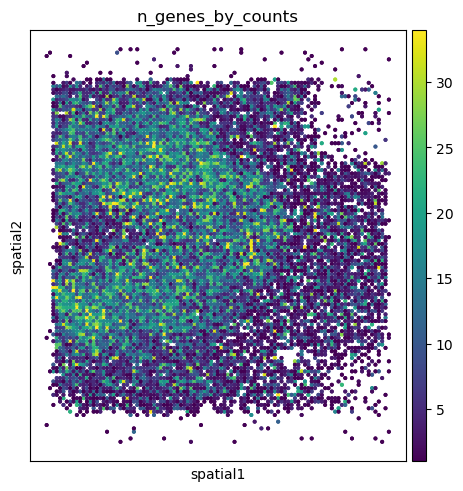

In [7]:
sc.pp.calculate_qc_metrics(sgdata,percent_top=None, log1p=False, inplace=True)
sq.pl.spatial_scatter(sgdata,shape=None,color=["n_genes_by_counts",],library_id='gRNA')

In [7]:
sgdata.var_names

Index(['sgAdrb2', 'sgAqp3', 'sgArntl', 'sgCd44', 'sgCd52', 'sgCxcl16',
       'sgDdit3', 'sgErgic2', 'sgFbxo7', 'sgFlot1', 'sgGata3', 'sgGlb1l2',
       'sgGpa33', 'sgIkbip', 'sgKcna3', 'sgKlrd1', 'sgL3mbtl3', 'sgMark3',
       'sgMcoln1', 'sgNmb', 'sgPiezo1', 'sgPomt1', 'sgPpia', 'sgS100a11',
       'sgScamp4', 'sgSlc39a8', 'sgSorl1', 'sgSrgn', 'sgTmem64', 'sgWipf1',
       'sgZc3h12a', 'sgZhx2', 'sgZscan12', 'sgnon-targeting'],
      dtype='object')

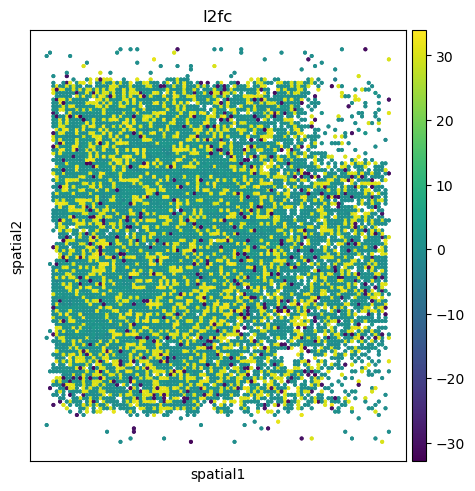

In [36]:
# This logic we calculate the relative L2FC of sgRNA vs sgNTC
# l2fc_bin = cnt(sgRNA_bin) / (cnt(sgNTC) + 1)
sgenes = sgdata.var_names
ESP = 1e-9

ntc_vec = sgdata[:, "sgnon-targeting"].X.toarray().flatten()

sgene = "sgGata3"
sg_vec = sgdata[:, sgene].X.toarray().flatten()
l2fc_vec = np.zeros(len(sg_vec))
for idx, cell in enumerate(sg_vec):
    l2fc_vec[idx] = np.log2(cell + ESP) - np.log2(ntc_vec[idx] + ESP)

sgdata.obs["l2fc"] = l2fc_vec
sq.pl.spatial_scatter(sgdata,shape=None,color=["l2fc",],library_id='gRNA')

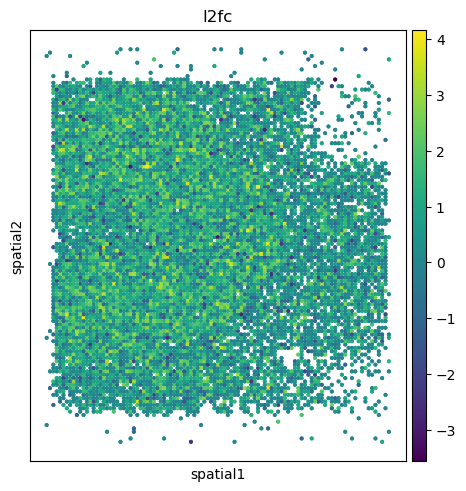

In [34]:
# This logic we calculate the relative L2FC of sgRNA vs sgNTC
# l2fc_bin = cnt(sgRNA_bin) / (cnt(sgNTC) + 1)
sgenes = sgdata.var_names
ESP = 1e-6

ntc_vec = sgdata[:, "sgnon-targeting"].X.toarray().flatten()

sgene = "sgGata3"
sg_vec = sgdata[:, sgene].X.toarray().flatten()
l2fc_vec = np.zeros(len(sg_vec))
for idx, cell in enumerate(sg_vec):
    l2fc_vec[idx] = np.log2(cell + 1) - np.log2(ntc_vec[idx] + 1)

sgdata.obs["l2fc"] = l2fc_vec
sq.pl.spatial_scatter(sgdata,shape=None,color=["l2fc",],library_id='gRNA')

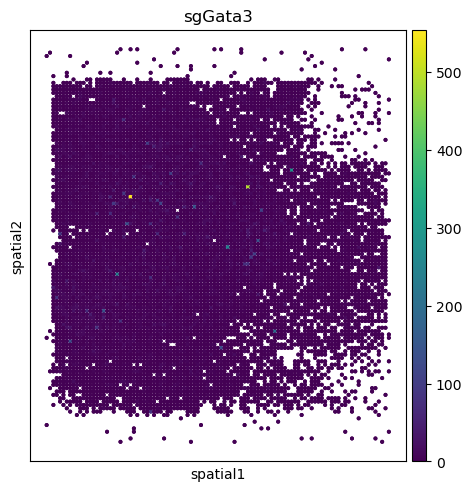

In [31]:
sq.pl.spatial_scatter(sgdata,shape=None,color=["sgGata3"],library_id='gRNA')

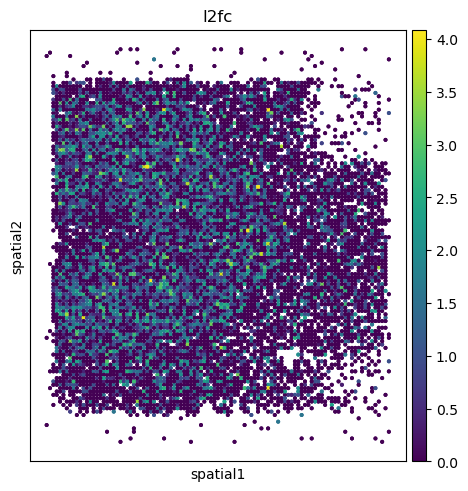

In [35]:
# This logic we calculate the relative L2FC of sgRNA vs sgNTC
# l2fc_bin = cnt(sgRNA_bin) / (cnt(sgNTC) + 1)
sgenes = sgdata.var_names
ESP = 1e-6

ntc_vec = sgdata[:, "sgnon-targeting"].X.toarray().flatten()

sgene = "sgGata3"
sg_vec = sgdata[:, sgene].X.toarray().flatten()
l2fc_vec = np.zeros(len(sg_vec))
for idx, cell in enumerate(sg_vec):
    if cell > ntc_vec[idx]:
        l2fc_vec[idx] = np.log2(cell) - np.log2(ntc_vec[idx] + 1)

sgdata.obs["l2fc"] = l2fc_vec
sq.pl.spatial_scatter(sgdata,shape=None,color=["l2fc",],library_id='gRNA')

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

interest_sgene = "sgnon-targeting"
apo_bin = sgdata[:, interest_sgene].X.toarray().flatten()

hypo_coord = tdata.obsm['spatial']
coord_df = pd.DataFrame({
    'x_coord': hypo_coord[:, 0],
    'y_coord': hypo_coord[:, 1],
    'value': apo_bin
})
coord_df_piv = pd.pivot_table(coord_df, values="value", index="y_coord", columns="x_coord", aggfunc=np.mean)

z = coord_df_piv.values
y = coord_df_piv.index
x = coord_df_piv.columns

cmap = plt.get_cmap("jet")

new_cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, 100)))
new_cmap.colors[:, -1] = np.linspace(0, 0.8, new_cmap.N) 

cs = axs.contourf(x, y, z, 8, cmap=new_cmap)
plt.colorbar(cs, ax=axs)

expression = 